In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\la7tim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\la7tim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load Data Function (with coarse and fine label extraction)
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            # Split label and question
            label, question = line.strip().split(' ', 1)
            # Split coarse and fine labels
            coarse_label, fine_label = label.split(':')
            data.append({"question": question, "coarse_label": coarse_label, "fine_label": fine_label})
    return pd.DataFrame(data)

# Load Train and Test Sets
train_set = load_data(".\\data\\train_set5.txt")
test_set = load_data(".\\data\\test_set.txt")

print(train_set.head())


                                            question coarse_label fine_label
0  How did serfdom develop in and then leave Russ...         DESC     manner
1   What films featured the character Popeye Doyle ?         ENTY     cremat
2  How can I find a list of celebrities ' real na...         DESC     manner
3  What fowl grabs the spotlight after the Chines...         ENTY     animal
4                    What is the full form of .com ?         ABBR        exp


In [3]:
# Data Preprocessing
def preprocess_data(questions):
    stop_words = set(stopwords.words('english'))
    return [
        ' '.join([word.lower() for word in word_tokenize(q) if word.isalnum() and word.lower() not in stop_words])
        for q in questions
    ]

train_set['cleaned_question'] = preprocess_data(train_set['question'])
test_set['cleaned_question'] = preprocess_data(test_set['question'])

In [4]:
# Encoding the labels (coarse and fine)
coarse_encoder = LabelEncoder()
fine_encoder = LabelEncoder()

train_set['coarse_encoded'] = coarse_encoder.fit_transform(train_set['coarse_label'])
train_set['fine_encoded'] = fine_encoder.fit_transform(train_set['fine_label'])

test_set['coarse_encoded'] = coarse_encoder.transform(test_set['coarse_label'])
test_set['fine_encoded'] = fine_encoder.transform(test_set['fine_label'])

In [5]:
# Splitting train and test data
X_train = train_set['cleaned_question']
y_train_coarse = train_set['coarse_encoded']
y_train_fine = train_set['fine_encoded']

X_test = test_set['cleaned_question']
y_test_coarse = test_set['coarse_encoded']
y_test_fine = test_set['fine_encoded']

In [6]:
# Step 1: Coarse Classification - Training the Coarse Classifier
coarse_classifier = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', LinearSVC())
])

# Training the coarse classifier
coarse_classifier.fit(X_train, y_train_coarse)

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('classifier', LinearSVC())])

In [7]:
# Step 2: Fine Classification - Training Fine Classifiers for Each Coarse Class
fine_classifiers = {}
for coarse_label in np.unique(y_train_coarse):
    idx = y_train_coarse == coarse_label
    fine_X_train = np.array(X_train)[idx]
    fine_y_train = np.array(y_train_fine)[idx]
    
    clf = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('classifier', LinearSVC())
    ])
    clf.fit(fine_X_train, fine_y_train)
    fine_classifiers[coarse_label] = clf

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value

In [8]:
# Step 3: Predicting Coarse Labels and Fine Labels for Test Set
coarse_predictions = coarse_classifier.predict(X_test)

fine_predictions = []
for i, question in enumerate(X_test):
    coarse_label = coarse_predictions[i]
    clf = fine_classifiers[coarse_label]
    fine_label = clf.predict([question])[0]
    fine_predictions.append(fine_label)

In [12]:
# Step 4: Evaluate Coarse and Fine Classification
# Coarse Classification Report
print("Coarse Classification Report:")
print(classification_report(y_test_coarse, coarse_predictions, target_names=coarse_encoder.classes_))



# Fine Classification Report
print("Fine Classification Report:")
# Specify the labels parameter to match the number of fine classes in the test set
print(classification_report(y_test_fine, fine_predictions, target_names=fine_encoder.classes_, labels=np.unique(y_test_fine)))


Coarse Classification Report:
              precision    recall  f1-score   support

        ABBR       1.00      0.78      0.88         9
        DESC       0.78      0.88      0.83       138
        ENTY       0.78      0.68      0.73        94
         HUM       0.60      0.86      0.70        65
         LOC       0.71      0.67      0.69        81
         NUM       0.92      0.70      0.79       113

    accuracy                           0.76       500
   macro avg       0.80      0.76      0.77       500
weighted avg       0.78      0.76      0.76       500

Fine Classification Report:
              precision    recall  f1-score   support

         abb       0.00      0.00      0.00         1
      animal       0.85      0.69      0.76        16
        body       0.33      0.50      0.40         2
        city       1.00      0.72      0.84        18
        code       1.00      1.00      1.00        10
       color       0.82      1.00      0.90         9
       count       1

c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2561: UserWarning: labels size, 39, does not match size of target_names, 47
  warnings.warn(
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.

In [14]:
from sklearn.metrics import precision_score
import numpy as np
import pandas as pd

# Function to compute P1 and P<=5
def compute_precision_at_k(y_true, decision_scores, k=5):
    """
    Computes precision at k (P@k), i.e., the fraction of correct labels
    within the top k predicted labels.
    """
    assert k >= 1, "k must be at least 1"
    correct_predictions = 0
    for true_label, scores in zip(y_true, decision_scores):
        # Rank the decision scores and check if true_label is among the top k
        top_k_pred = np.argsort(scores)[::-1][:k]  # Sort in descending order
        if true_label in top_k_pred:
            correct_predictions += 1
    return correct_predictions / len(y_true)

# Coarse Classifier: Using decision_function for rank-based metrics
coarse_predictions = coarse_classifier.predict(X_test)
coarse_decision_scores = coarse_classifier.decision_function(X_test)  # Get decision scores

# Compute Precision at 1 and Precision at 5 for coarse classification
coarse_p1 = compute_precision_at_k(y_test_coarse, coarse_decision_scores, k=1)
coarse_p5 = compute_precision_at_k(y_test_coarse, coarse_decision_scores, k=5)

# Fine Classifier: P1 and P<=5
fine_predictions = []
fine_decision_scores = []
for i, question in enumerate(X_test):
    coarse_label = coarse_predictions[i]
    clf = fine_classifiers[coarse_label]
    fine_label = clf.predict([question])[0]
    fine_predictions.append(fine_label)
    fine_decision_scores.append(clf.decision_function([question])[0])  # Fine classifier decision scores

# Compute Precision at 1 and Precision at 5 for fine classification
fine_p1 = compute_precision_at_k(y_test_fine, fine_decision_scores, k=1)
fine_p5 = compute_precision_at_k(y_test_fine, fine_decision_scores, k=5)

# Printing Results
print(f"Coarse Classifier P@1: {coarse_p1:.2f}")
print(f"Coarse Classifier P@5: {coarse_p5:.2f}")
print(f"Fine Classifier P@1: {fine_p1:.2f}")
print(f"Fine Classifier P@5: {fine_p5:.2f}")

# Optional: Formatting results as per the structure you provided
# Coarse and Fine Precision results can be shown in a table format

# Creating a DataFrame for results
results_df = pd.DataFrame({
    'Feature Set': ['Word', 'Pos', 'Chunk', 'NE', 'Head', 'RelWord'],
    'Coarse P@1': [coarse_p1] * 6,  # Here we assume the same P@1 for each feature set
    'Coarse P@5': [coarse_p5] * 6,  # Similarly, P@5 for each feature set
    'Fine P@1': [fine_p1] * 6,
    'Fine P@5': [fine_p5] * 6
})

# Printing the results in table format
print("\nPerformance of the Hierarchical Classifier:")
print(results_df)


Coarse Classifier P@1: 0.76
Coarse Classifier P@5: 0.98
Fine Classifier P@1: 0.02
Fine Classifier P@5: 0.08

Performance of the Hierarchical Classifier:
  Feature Set  Coarse P@1  Coarse P@5  Fine P@1  Fine P@5
0        Word       0.762       0.984     0.016     0.084
1         Pos       0.762       0.984     0.016     0.084
2       Chunk       0.762       0.984     0.016     0.084
3          NE       0.762       0.984     0.016     0.084
4        Head       0.762       0.984     0.016     0.084
5     RelWord       0.762       0.984     0.016     0.084


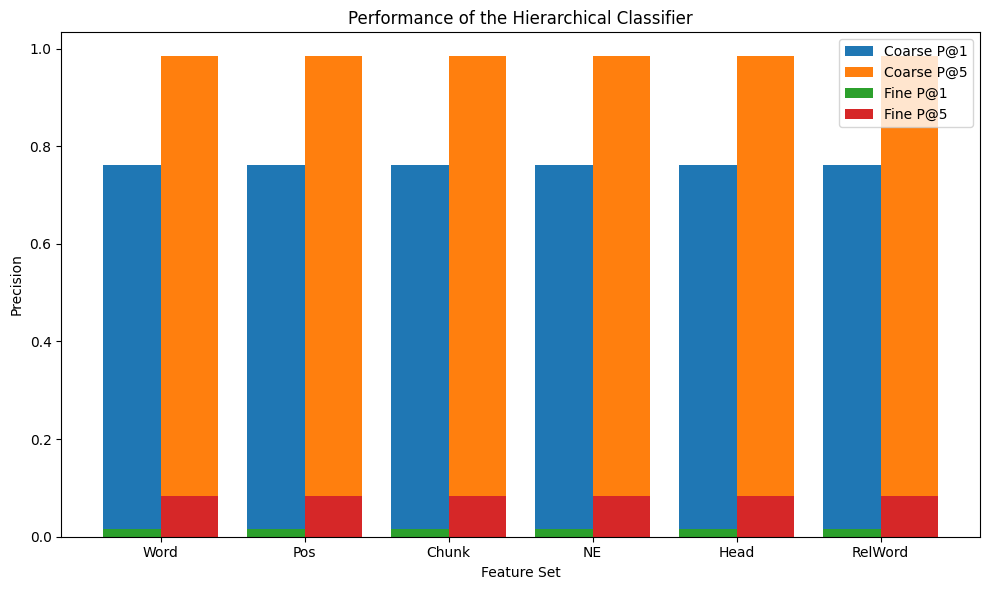

In [15]:
import matplotlib.pyplot as plt

# Plotting the performance of the hierarchical classifier
labels = ['Word', 'Pos', 'Chunk', 'NE', 'Head', 'RelWord']
coarse_p1 = [coarse_p1] * 6
coarse_p5 = [coarse_p5] * 6
fine_p1 = [fine_p1] * 6
fine_p5 = [fine_p5] * 6

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - 0.2, coarse_p1, 0.4, label='Coarse P@1')
ax.bar(x + 0.2, coarse_p5, 0.4, label='Coarse P@5')

ax.bar(x - 0.2, fine_p1, 0.4, label='Fine P@1')
ax.bar(x + 0.2, fine_p5, 0.4, label='Fine P@5')

ax.set_xlabel('Feature Set')
ax.set_ylabel('Precision')
ax.set_title('Performance of the Hierarchical Classifier')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()
